In [1]:
# Loading Libraries
import pandas as pd
import numpy as np
import re
import string
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to C:\Users\Ossama
[nltk_data]     E\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Ossama
[nltk_data]     E\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Loading Data
fake = pd.read_csv('fake.csv', encoding='ISO-8859-1')
real = pd.read_csv('true.csv', encoding='ISO-8859-1')

In [3]:
fake

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Yearâ...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obamaâs Na...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied âSafe Zoneâ Plan ...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [4]:
real

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [5]:
fake.shape

(23481, 4)

In [6]:
real.shape

(21417, 4)

In [7]:
# Add label column
fake['label'] = 1
real['label'] = 0

# Merge datasets
data = pd.concat([fake, real], ignore_index=True)

# Remove unnecessary columns
data.drop(columns=[col for col in data.columns if 'Unnamed' in col], inplace=True)

# Display data info
print(data.shape)
data.head()

(44898, 5)


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Yearâ...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obamaâs Na...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [8]:
# Counting how many duplicated texts exist in the "text" column
data["text"].duplicated().sum()

6252

In [9]:
# Preprocessing Text

# Loading stopwords
stop_words = set(stopwords.words('english'))

# Defining the preprocessing function
def preprocess_text(text):
    text = str(text).lower()  # Lowercasing
    text = text.encode('ascii', 'ignore').decode()  # Removing non-ASCII characters
    text = re.sub(r'\d+', '', text)  # Removing numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Removing punctuation
    tokens = text.split()  # Tokenizing
    tokens = [word for word in tokens if word not in stop_words]  # Removing stopwords
    lemmatizer = WordNetLemmatizer()  # Initializing lemmatizer
    tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatizing
    return ' '.join(tokens)  # Joining tokens back to a single string

# Applying the preprocessing function to the 'text' column
data['text'] = data['text'].apply(preprocess_text)

# Applying the preprocessing function to the 'title' column
data['title'] = data['title'].apply(preprocess_text)

# Combining 'title' and 'text' into a new column 'content'
data['content'] = data['title'] + ' ' + data['text']

# Dropping old columns no longer needed after combining
data.drop(columns=['title', 'text', 'subject', 'date'], inplace=True)

In [10]:
data

,label,content
0,1,donald trump sends embarrassing new year eve m...
1,1,drunk bragging trump staffer started russian c...
2,1,sheriff david clarke becomes internet joke thr...
3,1,trump obsessed even obamas name coded website ...
4,1,pope francis called donald trump christmas spe...
...,...,...
44893,0,fully committed nato back new u approach afgha...
44894,0,lexisnexis withdrew two product chinese market...
44895,0,minsk cultural hub becomes authority minsk reu...
44896,0,vatican upbeat possibility pope francis visiti...


In [11]:
# Adding a new column to store the number of words in each text
data['content length'] = data['content'].apply(lambda x: len(x.split()))

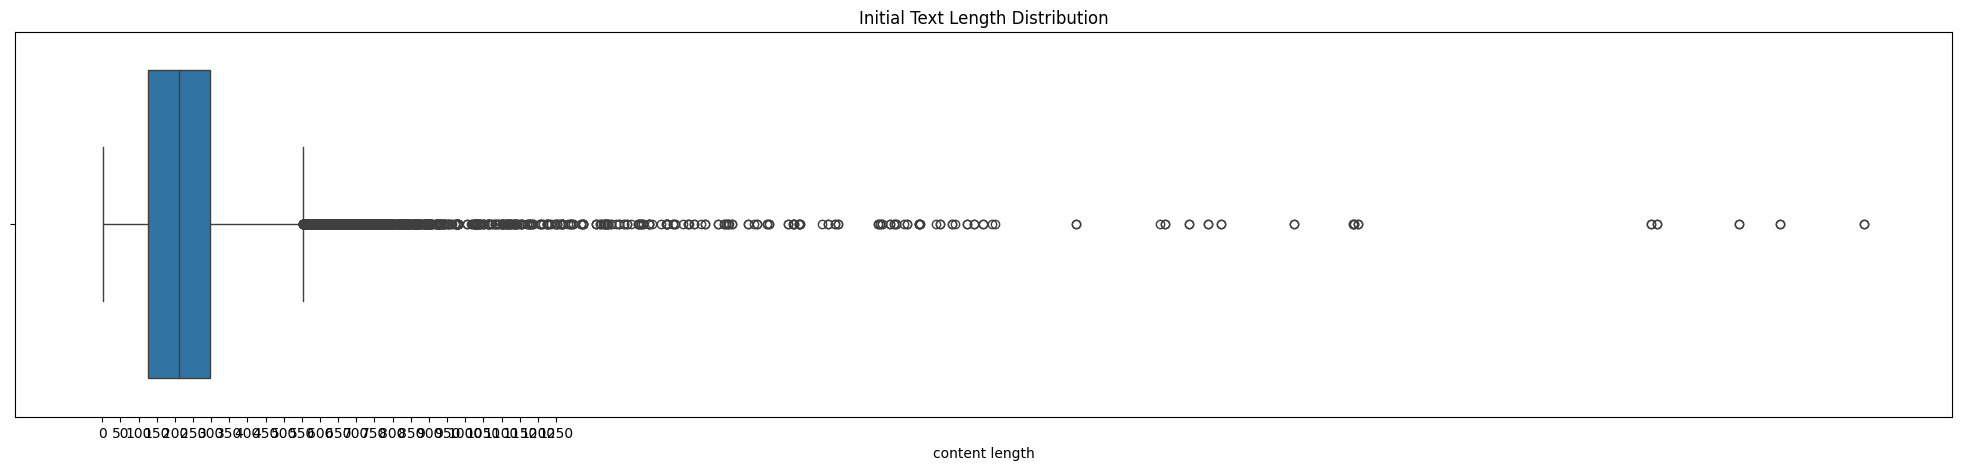

In [12]:
# Creating a boxplot to visualize the distribution of text lengths
plt.figure(figsize=(25,5))
sns.boxplot(x=data['content length'])
plt.xticks(ticks=range(0, 1300, 50))
plt.title('Initial Text Length Distribution')
plt.show()

In [13]:
# Filtering out texts with more than 850 words
data = data[data['content length'] < 850]

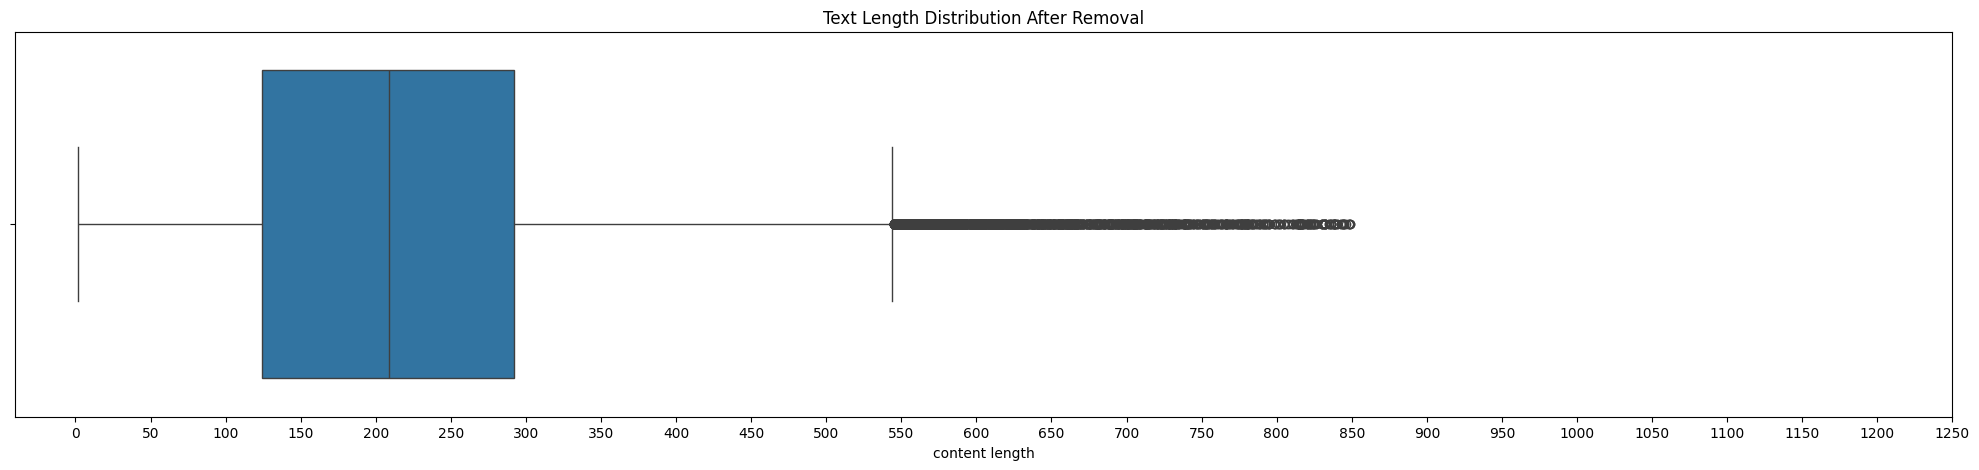

In [14]:
# Creating another boxplot after removing long texts
plt.figure(figsize=(25,5))
sns.boxplot(x=data['content length'])
plt.xticks(ticks=range(0, 1300, 50))  # Customizing x-axis ticks again
plt.title('Text Length Distribution After Removal')
plt.show()

In [15]:
# Dropping the temporary 'content length' column as it is no longer needed
data.drop('content length', axis=1, inplace=True)

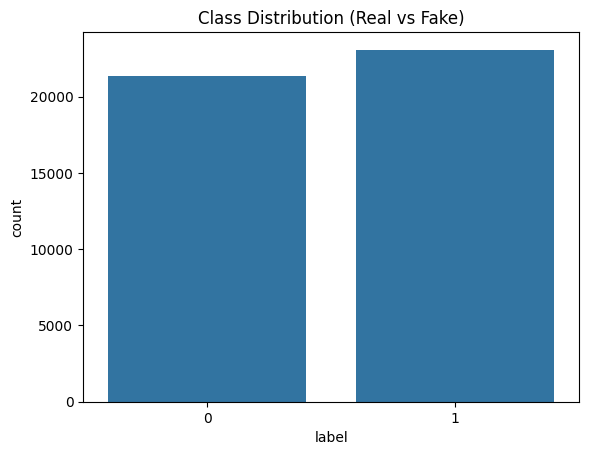

In [16]:
# Visualizing Class Distribution
sns.countplot(x=data['label'])
plt.title('Class Distribution (Real vs Fake)')
plt.show()

In [17]:
!pip install wordcloud

  Using cached wordcloud-1.9.4-cp311-cp311-win_amd64.whl (299 kB)



[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


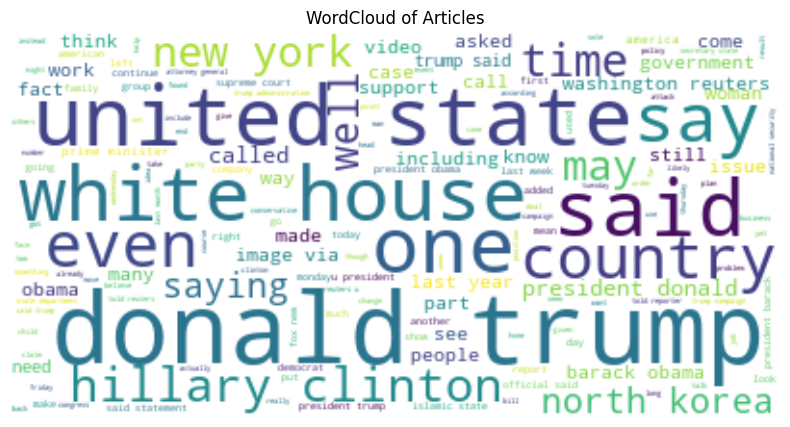

In [18]:
# Visualizing WordCloud
from wordcloud import WordCloud

plt.figure(figsize=(10,5))
wordcloud = WordCloud(background_color='white', max_words=1000).generate(' '.join(data['content']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Articles')
plt.show()

In [19]:
# Save the cleaned data into a new CSV file
data.to_csv("cleaned_data.csv", index=False, encoding='utf-8')

In [20]:
# plitting Dataset
X = data['content']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Vectorizing Text with TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

<h2>TF-IDF :It will convert text into numerical feature vectors so that machine learning models can understand it. </h2>

In [21]:
# Training Random Forest
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
rf.fit(X_train_tfidf, y_train)

# Predict
rf_pred = rf.predict(X_test_tfidf)

# Accuracy
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))

# Classification Report
print("Random Forest Classification Report:\n", classification_report(y_test, rf_pred))

# Computing and printing the confusion matrix
cm_rf = confusion_matrix(y_test, rf_pred)
print("Random Forest Confusion Matrix:\n", cm_rf)

Random Forest Accuracy: 0.9970756945225508
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4274
           1       1.00      1.00      1.00      4617

    accuracy                           1.00      8891
   macro avg       1.00      1.00      1.00      8891
weighted avg       1.00      1.00      1.00      8891

Random Forest Confusion Matrix:
 [[4261   13]
 [  13 4604]]


In [22]:
# Training Logistic Regression
lr = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)
lr.fit(X_train_tfidf, y_train)

# Predict
lr_pred = lr.predict(X_test_tfidf)

# Accuracy
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_pred))

# Classification Report
print("Logistic Regression Classification Report:\n", classification_report(y_test, lr_pred))

# Computing and printing the confusion matrix
cm_lr = confusion_matrix(y_test, lr_pred)
print("Logistic Regression Confusion Matrix:\n", cm_lr)

Logistic Regression Accuracy: 0.9901023506917107
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4274
           1       0.99      0.99      0.99      4617

    accuracy                           0.99      8891
   macro avg       0.99      0.99      0.99      8891
weighted avg       0.99      0.99      0.99      8891

Logistic Regression Confusion Matrix:
 [[4241   33]
 [  55 4562]]


In [23]:
# Training Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

# Predict
nb_pred = nb.predict(X_test_tfidf)

# Accuracy
print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_pred))

# Classification Report
print("Naive Bayes Classification Report:\n", classification_report(y_test, nb_pred))

# Computing and printing the confusion matrix
cm_nb = confusion_matrix(y_test, nb_pred)
print("Naive Bayes Confusion Matrix:\n", cm_nb)

Naive Bayes Accuracy: 0.9423012034641772
Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      4274
           1       0.94      0.95      0.94      4617

    accuracy                           0.94      8891
   macro avg       0.94      0.94      0.94      8891
weighted avg       0.94      0.94      0.94      8891

Naive Bayes Confusion Matrix:
 [[4002  272]
 [ 241 4376]]


In [24]:
# Training Linear SVM
svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)

# Predict
svm_pred = svm.predict(X_test_tfidf)

# Accuracy
print("Linear SVM Accuracy:", accuracy_score(y_test, svm_pred))

# Classification Report
print("Linear SVM Classification Report:\n", classification_report(y_test, svm_pred))

# Computing and printing the confusion matrix
cm_svm = confusion_matrix(y_test, svm_pred)
print("Linear SVM Confusion Matrix:\n", cm_svm)

Linear SVM Accuracy: 0.9958384883590148
Linear SVM Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4274
           1       1.00      1.00      1.00      4617

    accuracy                           1.00      8891
   macro avg       1.00      1.00      1.00      8891
weighted avg       1.00      1.00      1.00      8891

Linear SVM Confusion Matrix:
 [[4258   16]
 [  21 4596]]


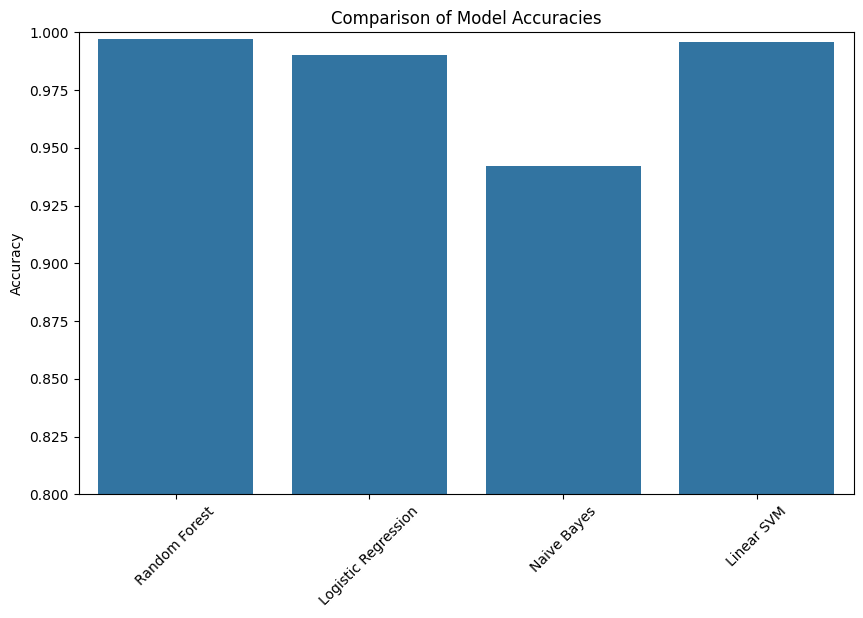

In [25]:
# Comparing Model Accuracies
accuracies = {
    'Random Forest': accuracy_score(y_test, rf_pred),
    'Logistic Regression': accuracy_score(y_test, lr_pred),
    'Naive Bayes': accuracy_score(y_test, nb_pred),
    'Linear SVM': accuracy_score(y_test, svm_pred)
}

# Barplot
plt.figure(figsize=(10,6))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.xticks(rotation=45)
plt.ylim(0.8, 1.0)
plt.show()

In [26]:
# New Prediction Pipeline for New Data
lemmatizer = WordNetLemmatizer()
def preprocess_new_text(text):
    """
    Preprocess a single text for prediction (same as training preprocessing).
    """
    text = str(text).lower()
    text = text.encode('ascii', 'ignore').decode()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

def predict_new_data(texts, true_labels):
    """
    Predicts multiple new texts and evaluates how models perform.
    texts: list of strings (news articles)
    true_labels: list of integers (0 = Real, 1 = Fake)
    """
    # Preprocess all texts
    clean_texts = [preprocess_new_text(text) for text in texts]

    # Vectorize all texts
    X_new = tfidf.transform(clean_texts)

    # Dictionary of models
    models = {
        "Random Forest": rf,
        "Logistic Regression": lr,
        "Naive Bayes": nb,
        "Linear SVM": svm
    }

    # For each model, predict and evaluate
    for model_name, model in models.items():
        preds = model.predict(X_new)
        correct = np.sum(preds == true_labels)
        total = len(true_labels)
        accuracy = correct / total

        print("=" * 80)
        print(f"Model: {model_name}")
        print(f"Correct Predictions: {correct}/{total}")
        print(f"Accuracy on New Data: {accuracy:.2f}")
        print("=" * 80)

        # Detailed predictions
        for idx, (pred, true) in enumerate(zip(preds, true_labels)):
            result = "✓ Correct" if pred == true else "✗ Wrong"
            pred_label = "Fake News" if pred == 1 else "Real News"
            true_label = "Fake News" if true == 1 else "Real News"
            print(f"Text {idx+1}: Predicted = {pred_label}, True = {true_label} --> {result}")
        print("\n")

In [27]:
# new political news examples
new_texts= [
    "Congress passes a landmark bill to improve election security and transparency.",  # Real news
    "Government secretly replaces all voting machines with mind-reading devices to control results."  # Fake news
]

# True labels corresponding to the texts
true_labels = [0, 1]

In [28]:
predict_new_data(new_texts, true_labels)

Model: Random Forest
Correct Predictions: 1/2
Accuracy on New Data: 0.50
Text 1: Predicted = Fake News, True = Real News --> ✗ Wrong
Text 2: Predicted = Fake News, True = Fake News --> ✓ Correct


Model: Logistic Regression
Correct Predictions: 1/2
Accuracy on New Data: 0.50
Text 1: Predicted = Fake News, True = Real News --> ✗ Wrong
Text 2: Predicted = Fake News, True = Fake News --> ✓ Correct


Model: Naive Bayes
Correct Predictions: 2/2
Accuracy on New Data: 1.00
Text 1: Predicted = Real News, True = Real News --> ✓ Correct
Text 2: Predicted = Fake News, True = Fake News --> ✓ Correct


Model: Linear SVM
Correct Predictions: 2/2
Accuracy on New Data: 1.00
Text 1: Predicted = Real News, True = Real News --> ✓ Correct
Text 2: Predicted = Fake News, True = Fake News --> ✓ Correct




In [29]:
import joblib

# Crée un dossier 
import os
os.makedirs("saved_models", exist_ok=True)

# Sauvegarder le TF-IDF
joblib.dump(tfidf, "saved_models/tfidf_vectorizer.pkl")

# Sauvegarder le modèle Naive Bayes
joblib.dump(nb, "saved_models/naive_bayes_model.pkl")

# Sauvegarder le modèle Linear SVM
joblib.dump(svm, "saved_models/svm_model.pkl")

print("✅ Modèles et vecteur TF-IDF sauvegardés avec succès !")

✅ Modèles et vecteur TF-IDF sauvegardés avec succès !
